In [101]:
!pip install -q tensorflow

In [ ]:
!pip install -q yfinance

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import plotly.graph_objs as go

import plotly.express as px


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [65]:
import yfinance as yf

symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-31'

bvsp_full = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Analise exploratoria

In [ ]:
bvsp_full.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200


<Axes: xlabel='Date'>

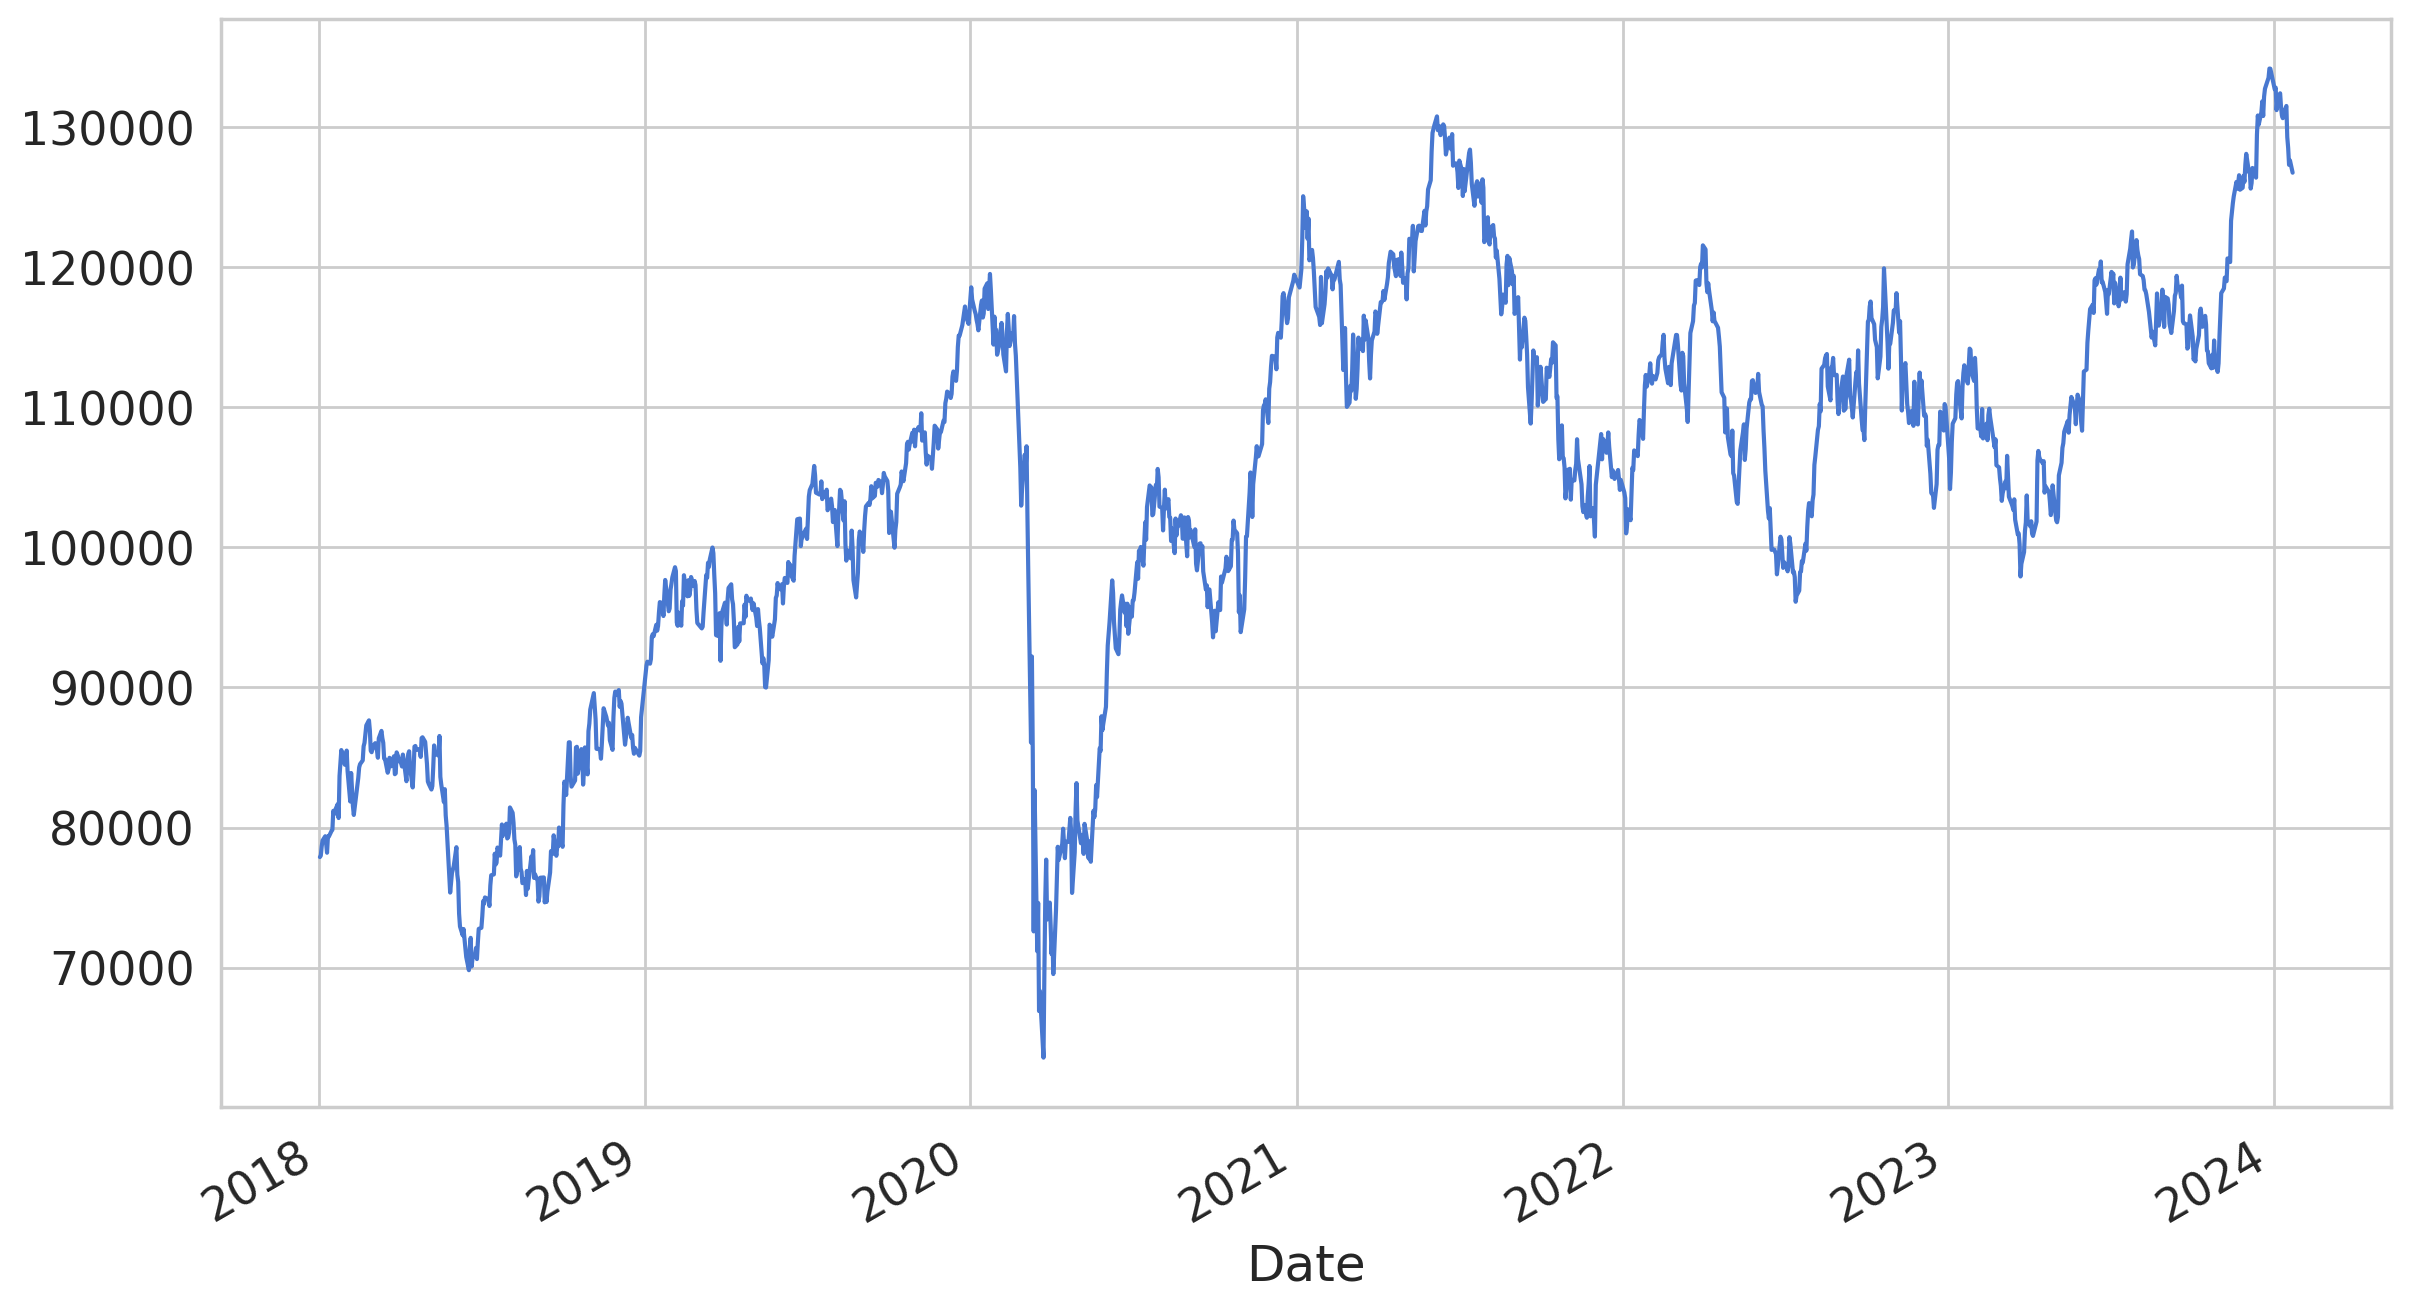

In [ ]:
bvsp_full['Adj Close'].plot()

In [68]:
# analisar apenas 2022 em diante

df = bvsp_full.loc[(bvsp_full.index >= '2023-01-01') & (bvsp_full.index < '2024-01-12')]

<Axes: xlabel='Date'>

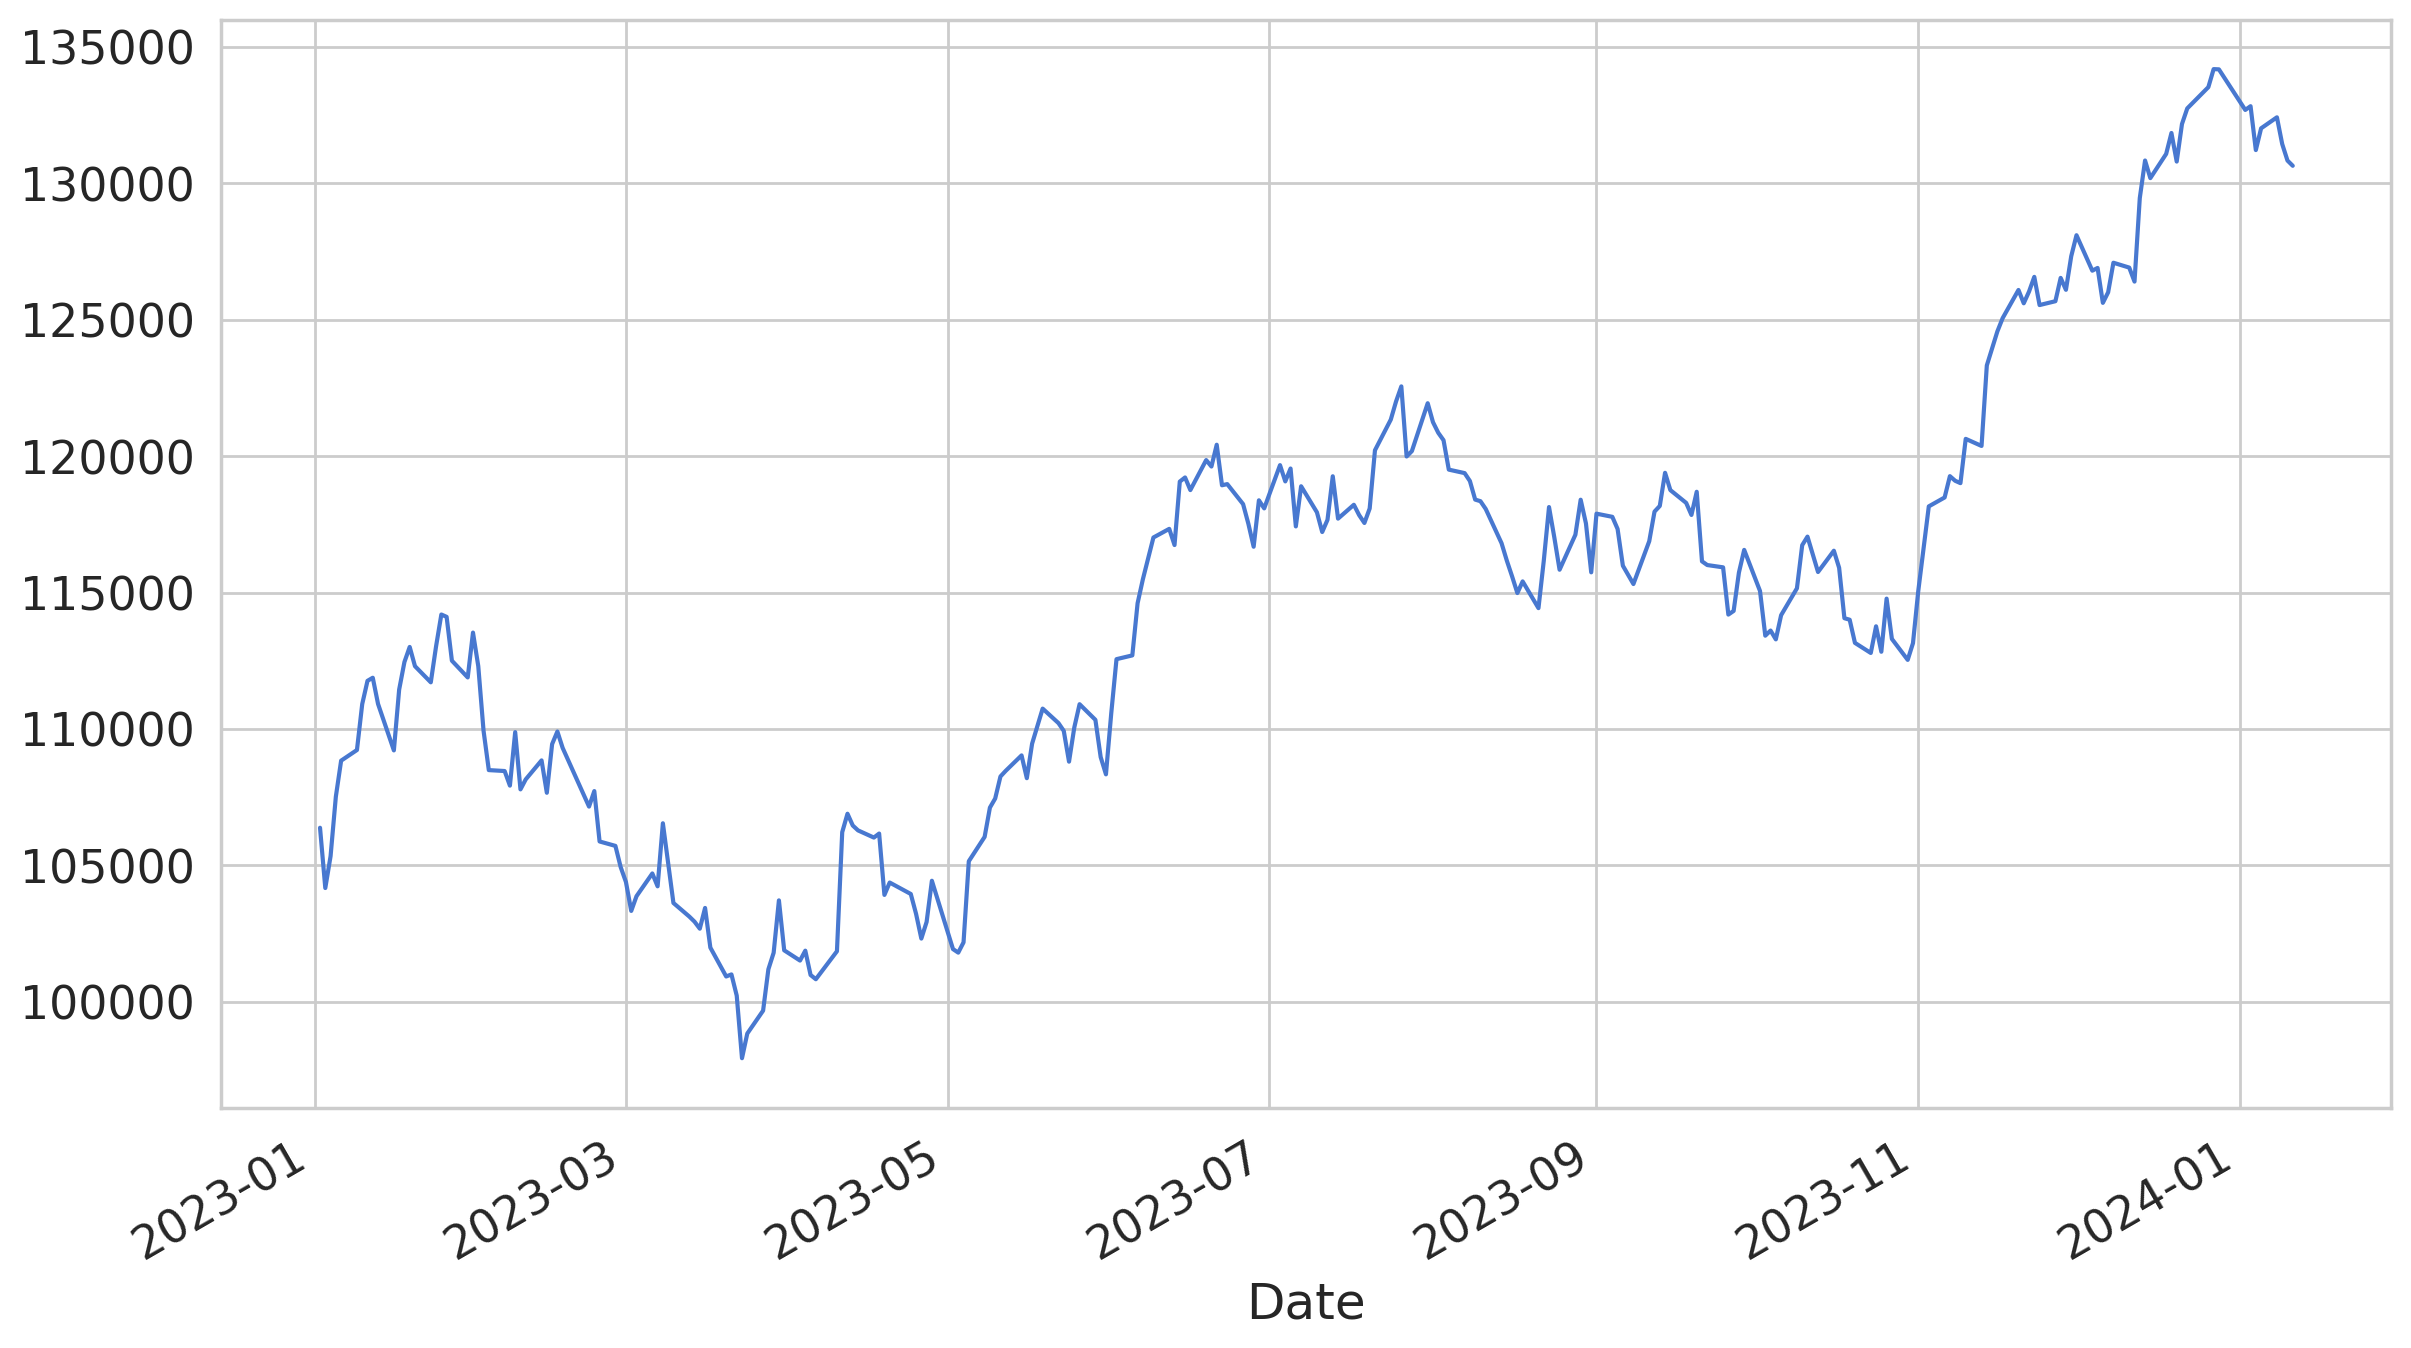

In [69]:
df['Adj Close'].plot()

In [70]:
df['Adj Close'].isna().sum()

0

In [71]:
df['Adj Close'].tail()

Date
2024-01-05    132023.0
2024-01-08    132427.0
2024-01-09    131447.0
2024-01-10    130841.0
2024-01-11    130649.0
Name: Adj Close, dtype: float64

In [72]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']

In [73]:
df.head(2)

,Adj Close
Date,
2023-01-02,106376.0
2023-01-03,104166.0


In [74]:
df.shape

(256, 1)

In [75]:
adj_close = df['Adj Close'].values.reshape(-1, 1)

# Criando um Scaler, definindo o intervalo de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustando o escalador aos dados e transformando-os
scaled_close = scaler.fit_transform(adj_close)

df['Scaled_Adj_Close'] = scaled_close

<Axes: ylabel='Density'>

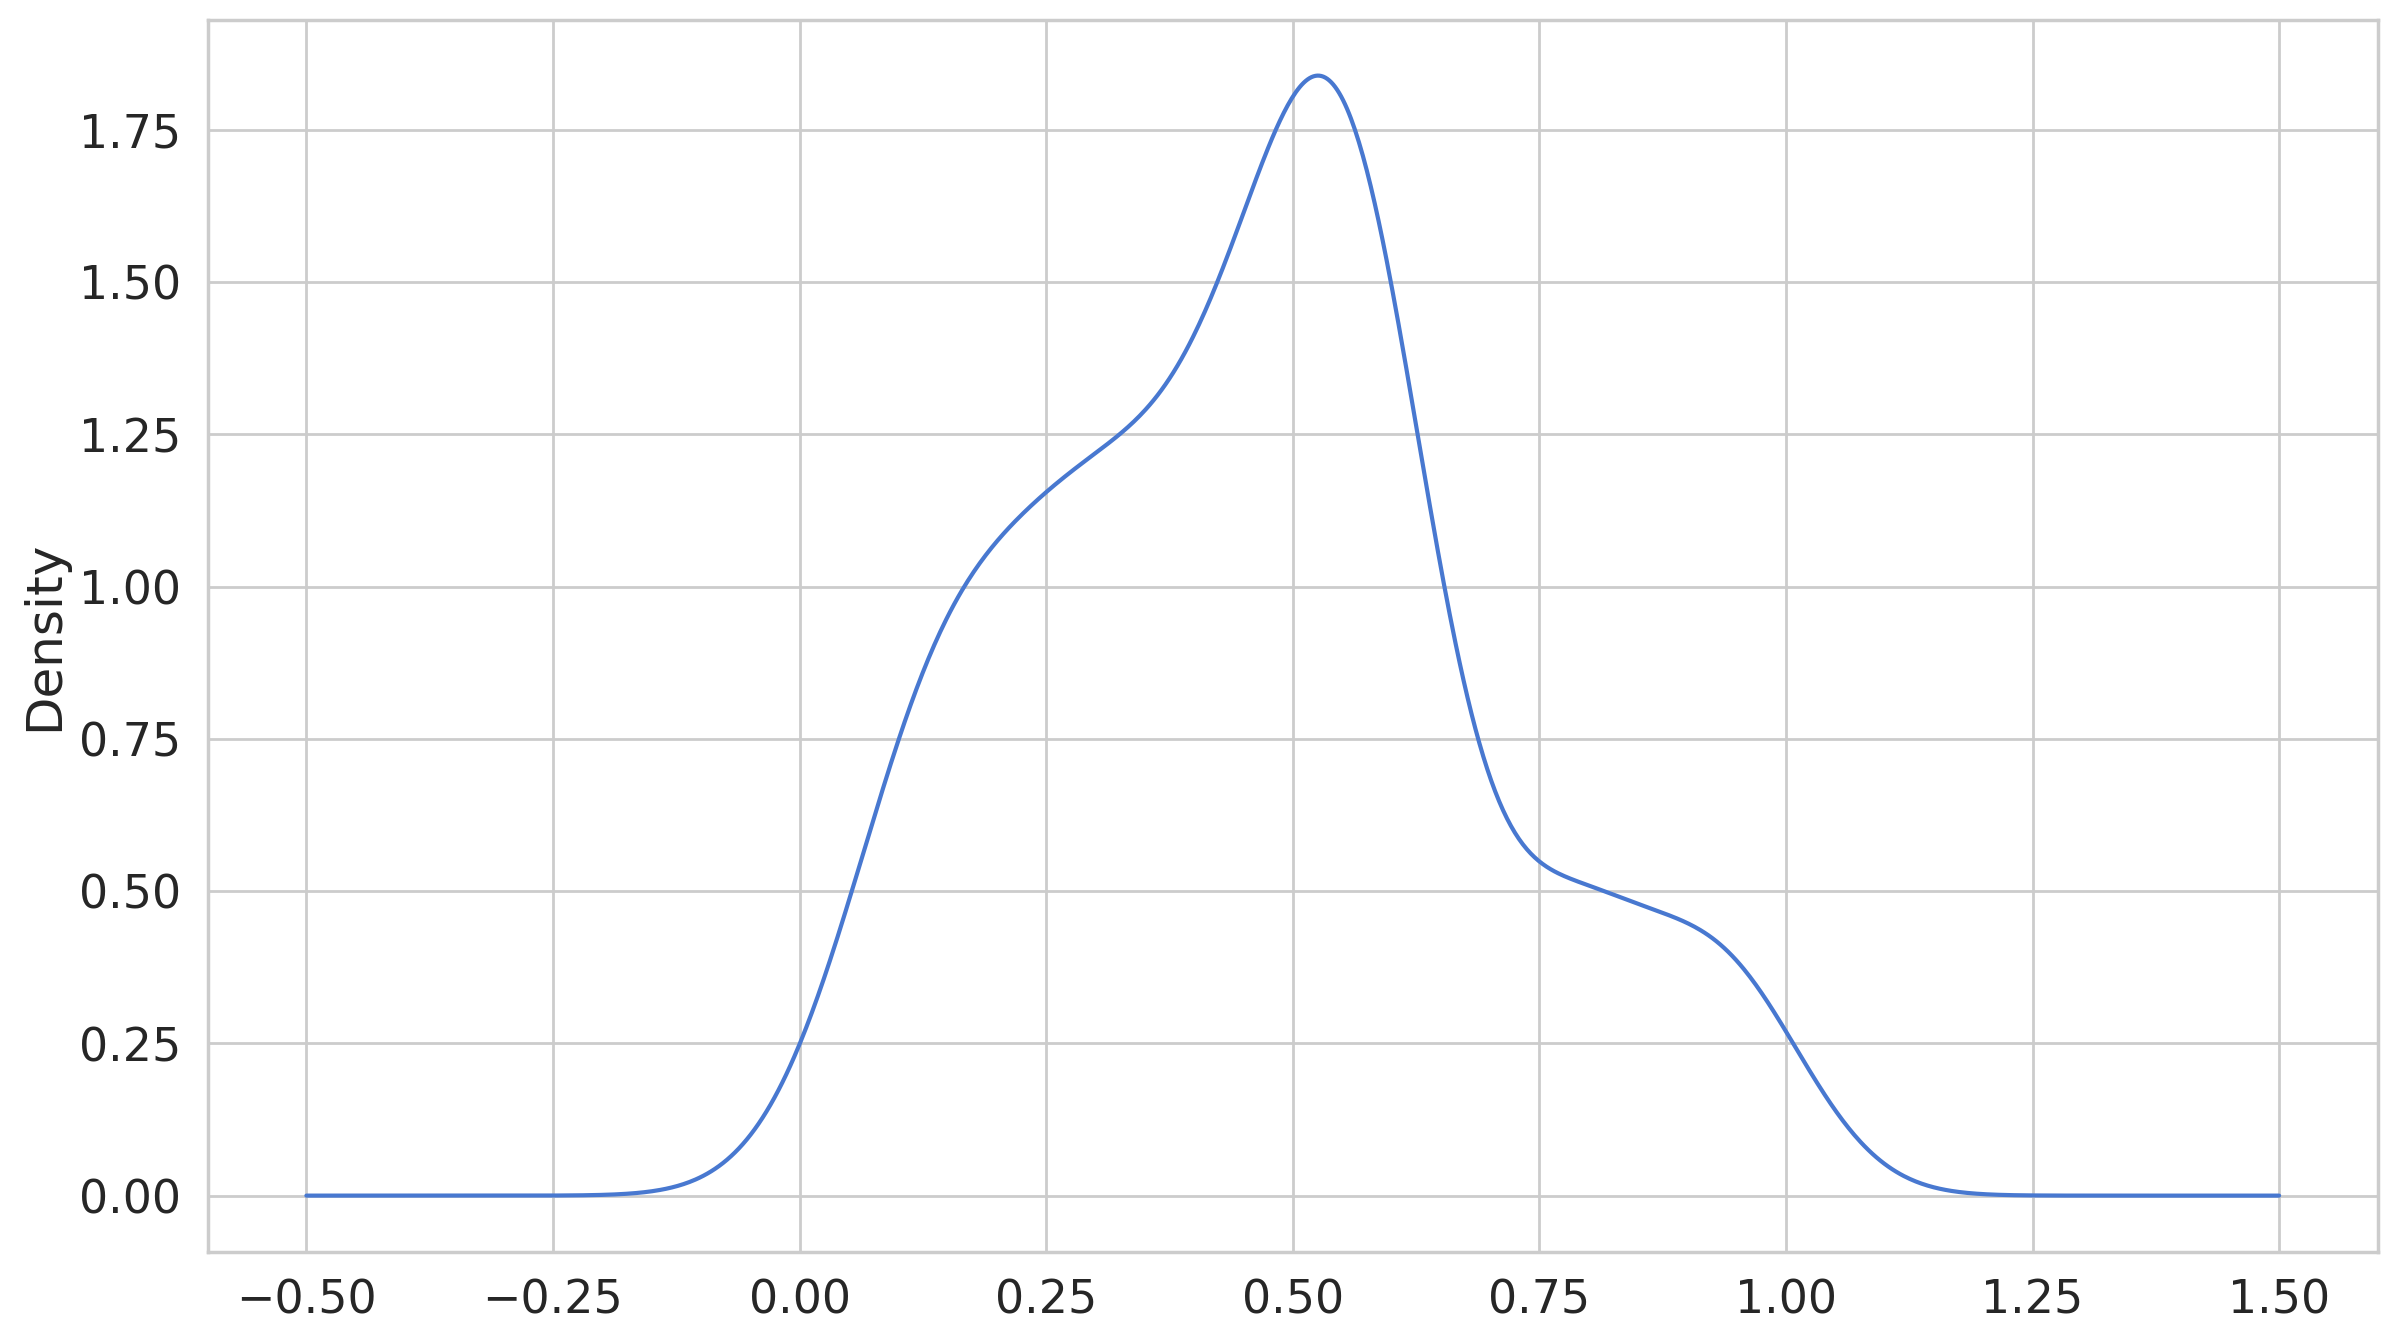

In [76]:
df['Scaled_Adj_Close'].plot(kind='kde')

# terceira tentativa

In [100]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

def download_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

# def preprocess_data(data, lookback_period, forecast_period):
#     columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume']
#     # data.drop(columns=columns_to_drop, inplace=True)

#     adj_close = data['Adj Close'].values.reshape(-1, 1)

#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled_close = scaler.fit_transform(adj_close)

#     X_train = []
#     Y_train = []

#     y = scaled_close

#     for i in range(lookback_period, len(y) - forecast_period + 1):
#         X_train.append(y[i - lookback_period: i])
#         Y_train.append(y[i: i + forecast_period])

#     X_train = np.array(X_train)
#     Y_train = np.array(Y_train)

#     return X_train, Y_train, scaler

def build_and_train_model(X_train, Y_train,X_test,Y_test, n_units, n_lookback, n_forecast, n_epochs, batch_size):
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(n_lookback, 1)))
    model.add(LSTM(units=n_units))
    model.add(Dense(n_forecast))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train,validation_data = (X_test,Y_test), epochs=n_epochs, batch_size=batch_size, verbose=0)

    return model

def generate_forecasts(model, scaler, X_train, X_test, n_lookback):
    print('X_train : ', X_train.shape)
    X_ = X_train.reshape(1, n_lookback, 1)
    print('X_ : ', X_.shape)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    print('X_test : ', X_test.shape)
    # X_t = X_test.reshape(1, n_lookback, 1)
    test_predict = model.predict(X_test).reshape(-1, 1)
    test_predict = scaler.inverse_transform(Y_)
    return Y_ , test_predict

def calculate_mse(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    return mse

In [357]:
def generate_forecasts(model, scaler, X_train, X_test, n_lookback):
    X_ = X_train.reshape(1, n_lookback, 1)
    XX_ = model.predict(X_).reshape(-1, 1)
    XXX_ = scaler.inverse_transform(XX_)

    # Z_ = X_test.reshape(1, n_lookback, 1)
    # test_pred = model.predict(Z_).reshape(-1, 1)
    # test_pred = scaler.inverse_transform(test_pred)

    # print(math.sqrt(mean_squared_error(X_,XX_)))
    # print(math.sqrt(mean_squared_error(Y_test[-1],test_predict)))

    return XXX_ #, test_pred

In [4]:
def visualize_results(actual, forecast):
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(forecast, label='Forecast', linestyle='--', marker='o')
    plt.title('Actual vs. Forecast')
    plt.xlabel('Time Period')
    plt.ylabel('Scaled Adj Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [246]:
def preprocess_data(data, lookback_period, forecast_period, test_size=0.2, fetures=['Adj Close'], ):
    adj_close = []
    if len(fetures) == 1:
      adj_close = data[fetures].values.reshape(-1, 1)
    else:
      adj_close = data[fetures].values

    scaler = MinMaxScaler(feature_range=(0, len(fetures)))
    scaled_close = scaler.fit_transform(adj_close)

    X = []
    Y = []

    y = scaled_close

    for i in range(lookback_period, len(y) - forecast_period + 1):
        X.append(y[i - lookback_period: i])
        Y.append(y[i: i + forecast_period])

    X = np.array(X)
    Y = np.array(Y)

    # Calcular o índice para dividir entre treinamento e teste
    # split_index = int(len(X) * (1 - test_size))

    # X_train, Y_train = X[:split_index], Y[:split_index]
    # X_test, Y_test = X[split_index:], Y[split_index:]

    return X, Y , scaler# X_train, Y_train, X_test, Y_test, scaler



In [188]:
symbol = '^BVSP'
start_date = '2022-01-01'
end_date = '2024-01-18'
array_lookback_period = [30, 60] #[3,5,15, 30, 60] periodos menores tem menos acertividade
array_forecast_period = [3,4,5] #units: Positive integer, dimensionality of the output space.
array_n_units = [32,50]   # Inteiro positivo, dimensionalidade do espaço de saída.
array_batch_size = [64,100] # Número de amostras por atualização de gradiente. Se não for especificado, o padrão batch_size será 32. Não especifique o batch_size se seus dados estiverem na forma de conjuntos de dados, geradores ou instâncias keras.utils.Sequence (já que eles geram lotes).
n_epochs = 100 # Número de épocas para treinar o modelo. Uma época é uma iteração sobre todos os dados xey fornecidos (a menos que o sinalizador steps_per_epoch esteja definido como algo diferente de None). Observe que em conjunto com a época_inicial, as épocas devem ser entendidas como "época final". O modelo não é treinado para um número de iterações dadas por épocas, mas apenas até que a época das épocas do índice seja atingida.

In [78]:
# baixando dados atuais para comparação no futuro
data_actual = download_data(symbol, '2024-01-18', '2024-01-24')
data_actual =  data_actual[['Adj Close']]

data = download_data(symbol, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

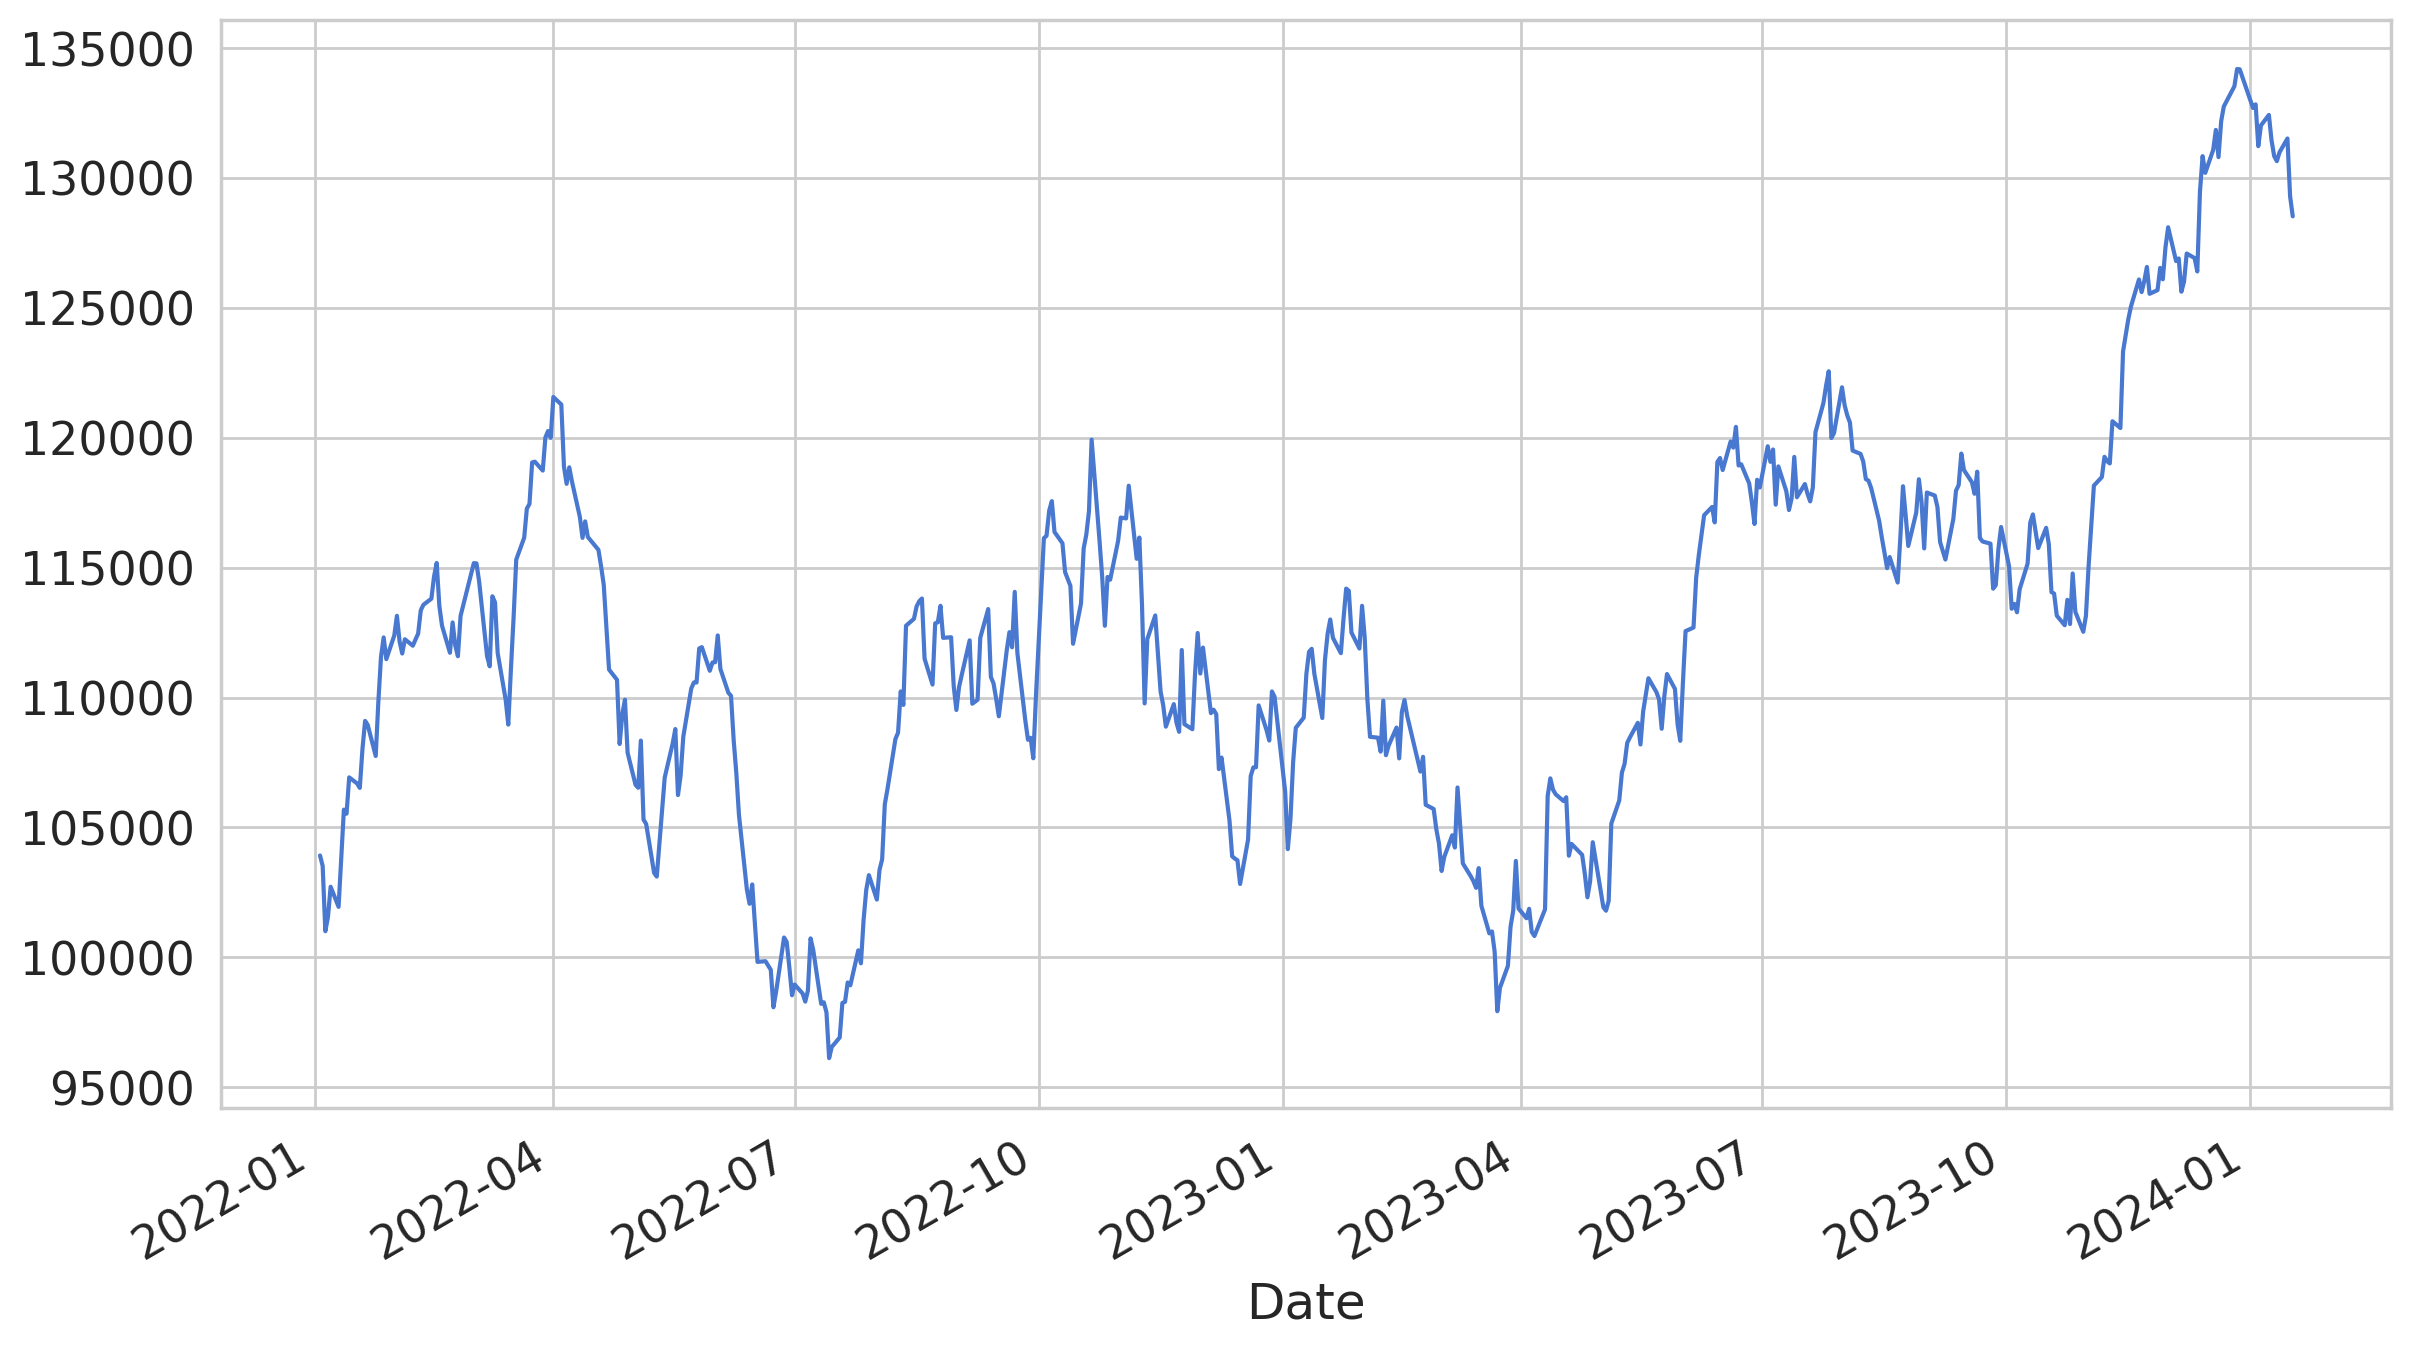

In [79]:
data['Adj Close'].plot()

In [80]:
del data['Open']
del data['High']
del data['Low']
del data['Close']
del data['Volume']
data.head(2)

,Adj Close
Date,
2022-01-03,103922.0
2022-01-04,103514.0
2022-01-05,101006.0
2022-01-06,101561.0
2022-01-07,102719.0
...,...
2024-01-11,130649.0
2024-01-12,130988.0
2024-01-15,131521.0


As Bandas de Bollinger consistem em três linhas: a SMA (média móvel simples), uma banda superior e uma banda inferior. As bandas superior e inferior são calculadas em relação à SMA e ao desvio padrão dos preços de fechamento. Vamos  calcular as Bandas de Bollinger com um desvio padrão de 2 em relação à SMA de 20 dias (inputs padrões utilizado na plataforma https://br.investing.com/indices/bovespa-chart):

A ideia é adicionar essa nova feture para melhorar o modelo


In [146]:
n = 20  # Período da SMA
k = 2  # Número de desvios padrão

data['SMA'] = data['Adj Close'].rolling(window=n).mean()
data['Std'] = data['Adj Close'].rolling(window=n).std()

# Bandas de Bollinger
data['Upper_Bollinger'] = data['SMA'] + (k * data['Std'])
data['Lower_Bollinger'] = data['SMA'] - (k * data['Std'])
del data['Std']


<Axes: xlabel='Date'>

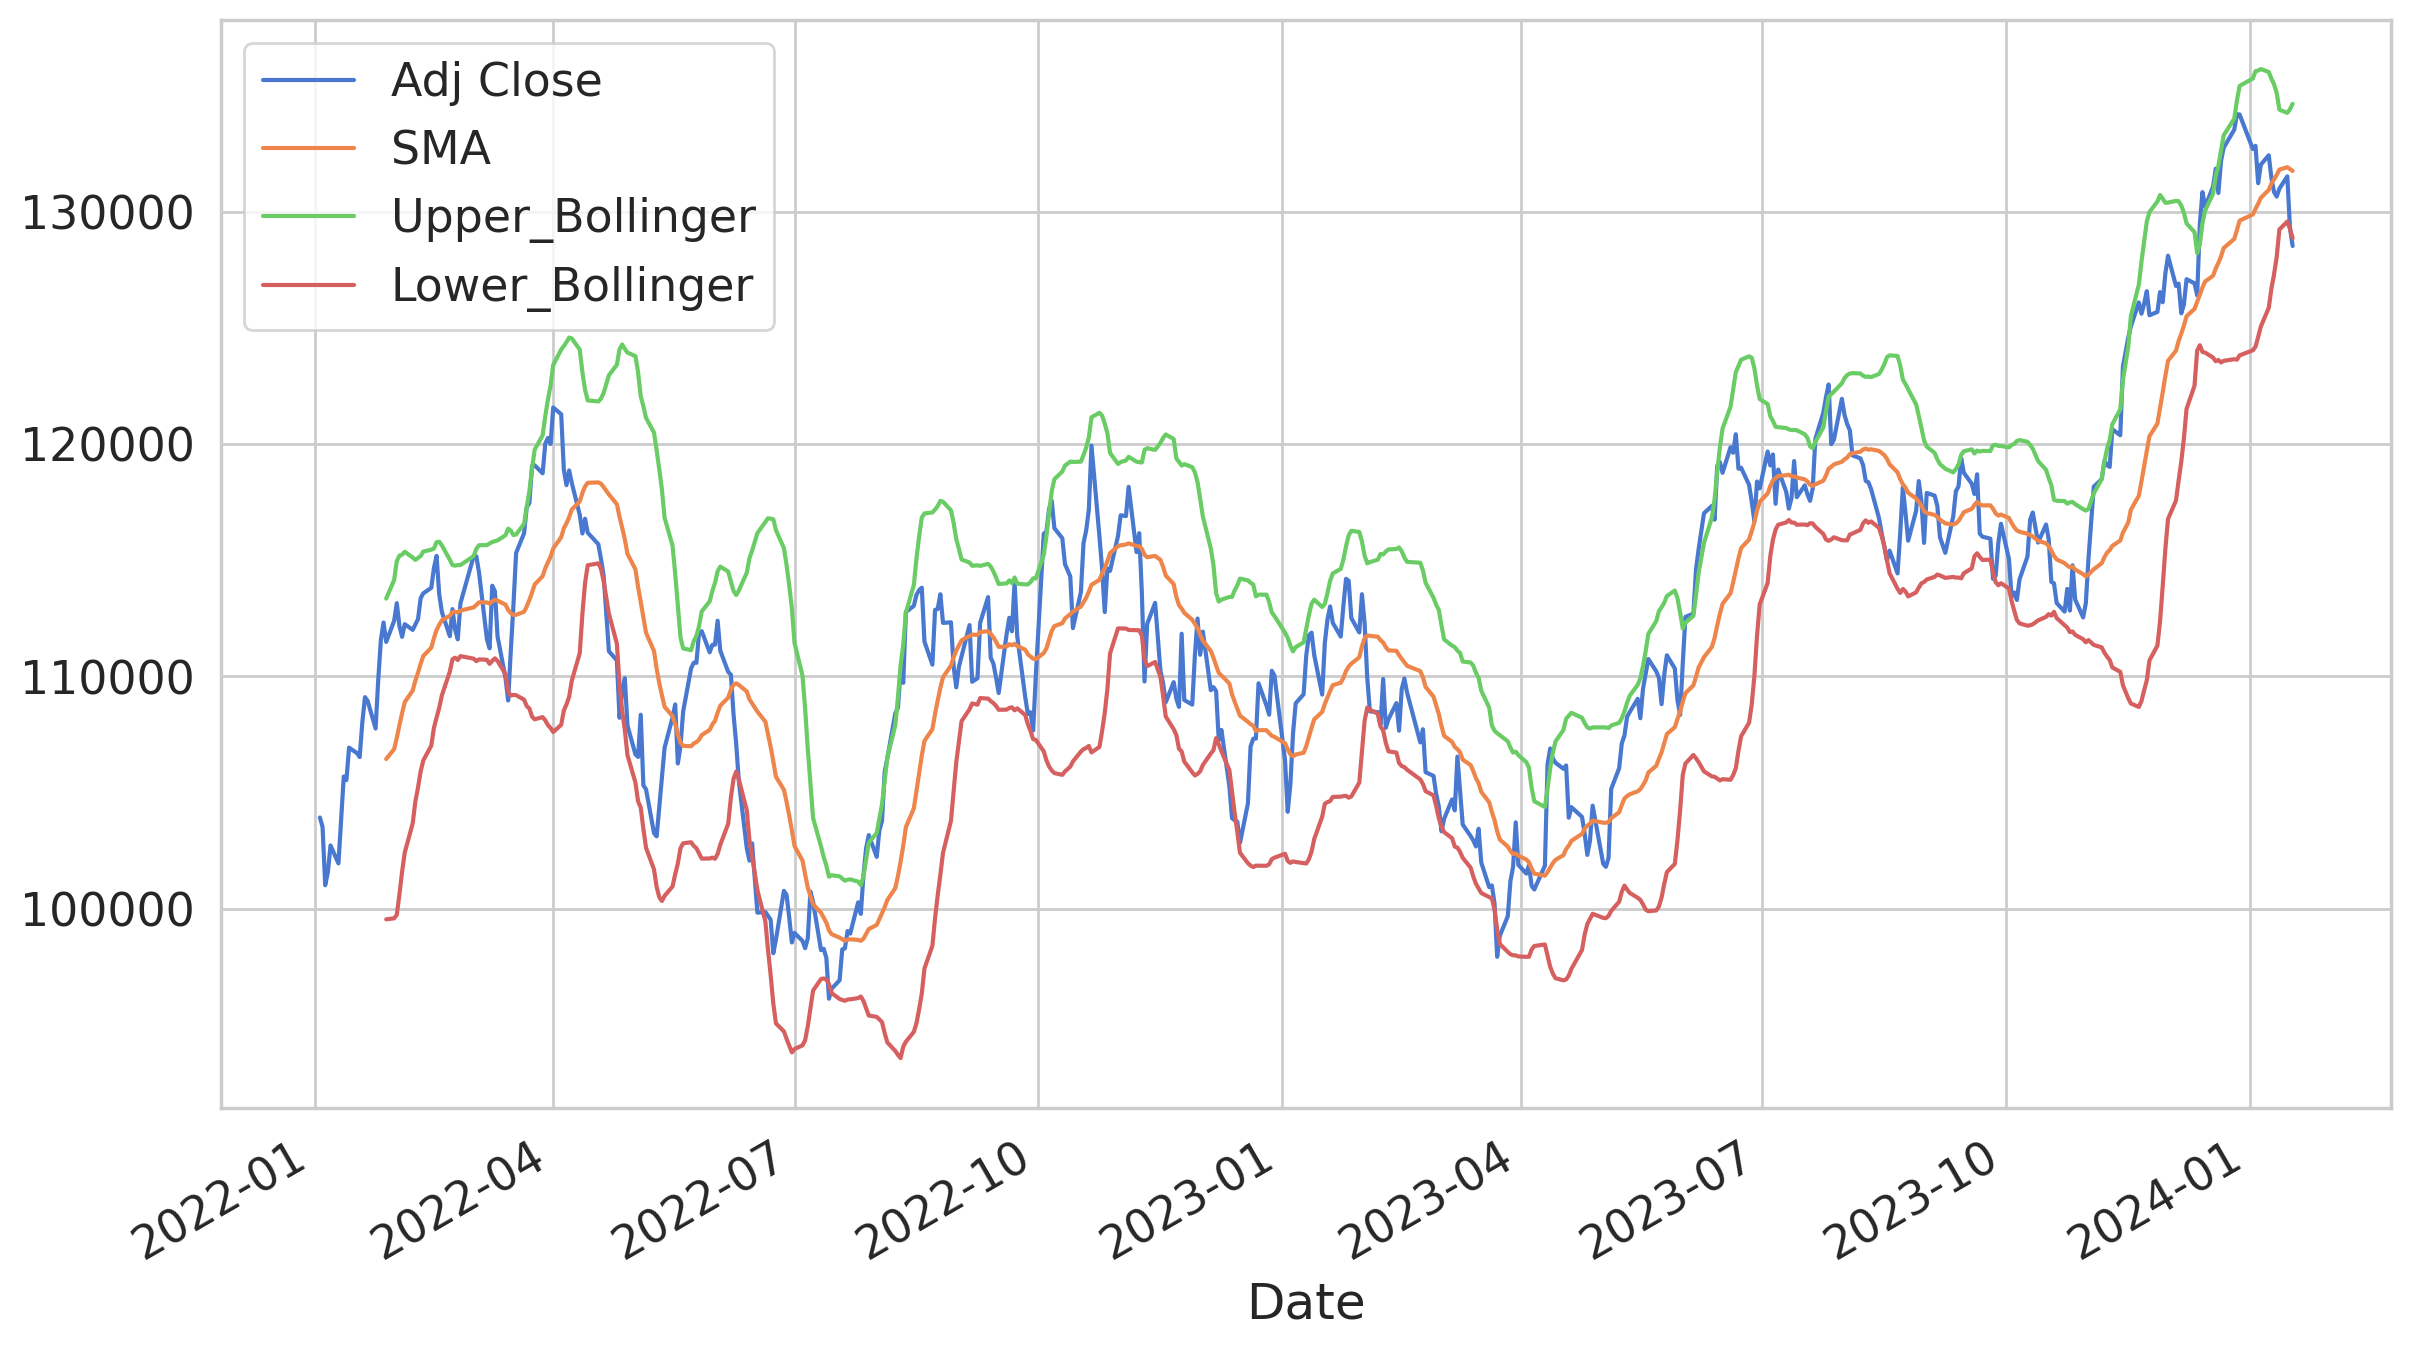

In [147]:
data.plot()

In [149]:
data.dropna(inplace=True)

In [151]:
import warnings
warnings.filterwarnings('ignore')


In [154]:
n_features = 4 # numero de features/columns

# def build_and_train_model(X_train, Y_train,X_test,Y_test, n_units, n_lookback, n_forecast, n_epochs, batch_size):
def build_and_train_model(X_train, Y_train, n_units, n_lookback, n_forecast, n_epochs, batch_size):
    model = Sequential()
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(n_lookback, n_features)))
    model.add(LSTM(units=n_units))
    # model.add(Dropout(0.2))
    model.add(Dense(n_forecast))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.fit(X_train, Y_train,validation_data = (X_test,Y_test), epochs=n_epochs, batch_size=batch_size, verbose=1)
    model.fit(X_train, Y_train,epochs=n_epochs, batch_size=batch_size, verbose=0)   #validation_split=0.2 um desafio que não entendi é que sempre que tento validar o modelo a performance piora

    return model


## Escolhendo os melhores parametros

In [18]:
for lookback_period in array_lookback_period:
  for forecast_period in array_forecast_period:
    for n_units in array_n_units:
      for batch_size in array_batch_size:
        X_train, Y_train, scaler = preprocess_data(data, lookback_period, forecast_period)
        print(f'Tamanho do conjunto de treinamento (X_train): {len(X_train)}')
        model = build_and_train_model(X_train, Y_train, n_units, lookback_period, forecast_period, n_epochs, batch_size)
        forecasts = generate_forecasts(model, scaler, X_train[-1], _ ,lookback_period)
        print(forecasts)

Tamanho do conjunto de treinamento (X_train): 228
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 12771 (49.89 KB)
Trainable params: 12771 (49.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 1s 854ms/step
[[130694.17]
 [130795.34]
 [130759.15]]
Tamanho do conjunto de treinamento (X_train): 228
Model: "sequential_1"
_________________________________________________________________
 La

1/1 [==============================] - 1s 807ms/step
[[132292.28]
 [132073.67]
 [131971.11]
 [132181.84]]
Tamanho do conjunto de treinamento (X_train): 227
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 32)            4352      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 12804 (50.02 KB)
Trainable params: 12804 (50.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 1s 811ms/step
[[132531.77]
 [133079.5 ]
 [132345.3 ]
 [132854.47]]
Tamanho do conjunto de treinamento (X_train): 227
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 4)                 204       
                                                                 
Total params: 30804 (120.33 KB)
Trainable params: 30804 (120.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 1s 1s/step
[[131352.64]
 [131924.73]
 [131915.48]
 [131850.19]]
Tamanho do conjunto d

## Aplicando os melhores parametros

In [272]:
fetures = ['Adj Close', 'SMA', 'Upper_Bollinger', 'Lower_Bollinger']
n_fetures = len(fetures)

In [338]:
from tensorflow.keras.layers import LSTM, Dense, Reshape

# Supondo que `data` é o seu DataFrame e 'lookback_period' e 'forecast_period' são definidos
lookback_period = 60
forecast_period = 3
n_units = 50
batch_size = 64
n_epochs = 200
n_fetures = len(fetures)

adj_close = []
if len(fetures) == 1:
  adj_close = data[fetures].values.reshape(-1, 1)
else:
  adj_close = data[fetures].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(adj_close)

X = []
Y = []

y = scaled_close

for i in range(lookback_period, len(y) - forecast_period + 1):
    X.append(y[i - lookback_period:i])
    Y.append(y[i:i + forecast_period])

X_train = np.array(X)
Y_train = np.array(Y)

# Divisão em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


In [339]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (343, 60, 4)
Y_train shape: (343, 3, 4)
X_test shape: (86, 60, 4)
Y_test shape: (86, 3, 4)


In [340]:
# Modelo
model = Sequential()
model.add(LSTM(units=n_units, return_sequences=True, input_shape=(lookback_period, n_fetures)))
model.add(LSTM(units=n_units))
model.add(Dense(forecast_period * n_fetures)) # Ajustando a camada Dense
model.add(Reshape((forecast_period, n_fetures))) # Adicionando uma camada de redimensionamento
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 60, 50)            11000     
                                                                 
 lstm_169 (LSTM)             (None, 50)                20200     
                                                                 
 dense_83 (Dense)            (None, 12)                612       
                                                                 
 reshape_7 (Reshape)         (None, 3, 4)              0         
                                                                 
Total params: 31812 (124.27 KB)
Trainable params: 31812 (124.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [341]:
# Fazendo previsões
Y_pred = model.predict(X_test)

# Redimensionando Y_test e Y_pred para o cálculo do MSE
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1] * n_fetures)
Y_pred_reshaped = Y_pred.reshape(Y_pred.shape[0], Y_pred.shape[1] * n_fetures)

# Calculando o MSE
mse = mean_squared_error(Y_test_reshaped, Y_pred_reshaped)
print(f"MSE: {mse}")


3/3 [==============================] - 1s 17ms/step
MSE: 0.002985989761545497


In [342]:
# Preparar dados para previsão
# Pegue os últimos 'lookback_period' pontos do DataFrame
last_points = data[fetures].tail(lookback_period)
last_points_scaled = scaler.transform(last_points)

# Redimensione para o formato esperado pelo modelo
X_predict = np.array([last_points_scaled])

# Fazer previsões
predicted_scaled = model.predict(X_predict)

# Redimensionar as previsões para o formato usado no 'inverse_transform'
predicted_scaled = predicted_scaled.reshape(-1, len(fetures))

# Aplicar inverse_transform para converter as previsões de volta à escala original
predicted = scaler.inverse_transform(predicted_scaled)

# Converter as previsões em um DataFrame para facilitar a visualização/manipulação
predicted_df = pd.DataFrame(predicted, columns=fetures)
predicted_df

1/1 [==============================] - 0s 31ms/step


,Adj Close,SMA,Upper_Bollinger,Lower_Bollinger
0,129555.945312,127303.859375,129810.695312,126285.718750
1,129614.437500,127264.578125,129921.968750,127079.828125
2,127880.921875,129373.007812,129078.976562,128536.632812


In [343]:
# Selecionando os últimos pontos dos dados reais para plotar
real_data_to_plot = data.tail(lookback_period)

# Resetando os índices para facilitar a concatenação
real_data_to_plot = real_data_to_plot.reset_index(drop=True)
predicted_df = predicted_df.reset_index(drop=True)

# Concatenando os dados reais com as previsões
combined_data = pd.concat([real_data_to_plot, predicted_df], ignore_index=True)


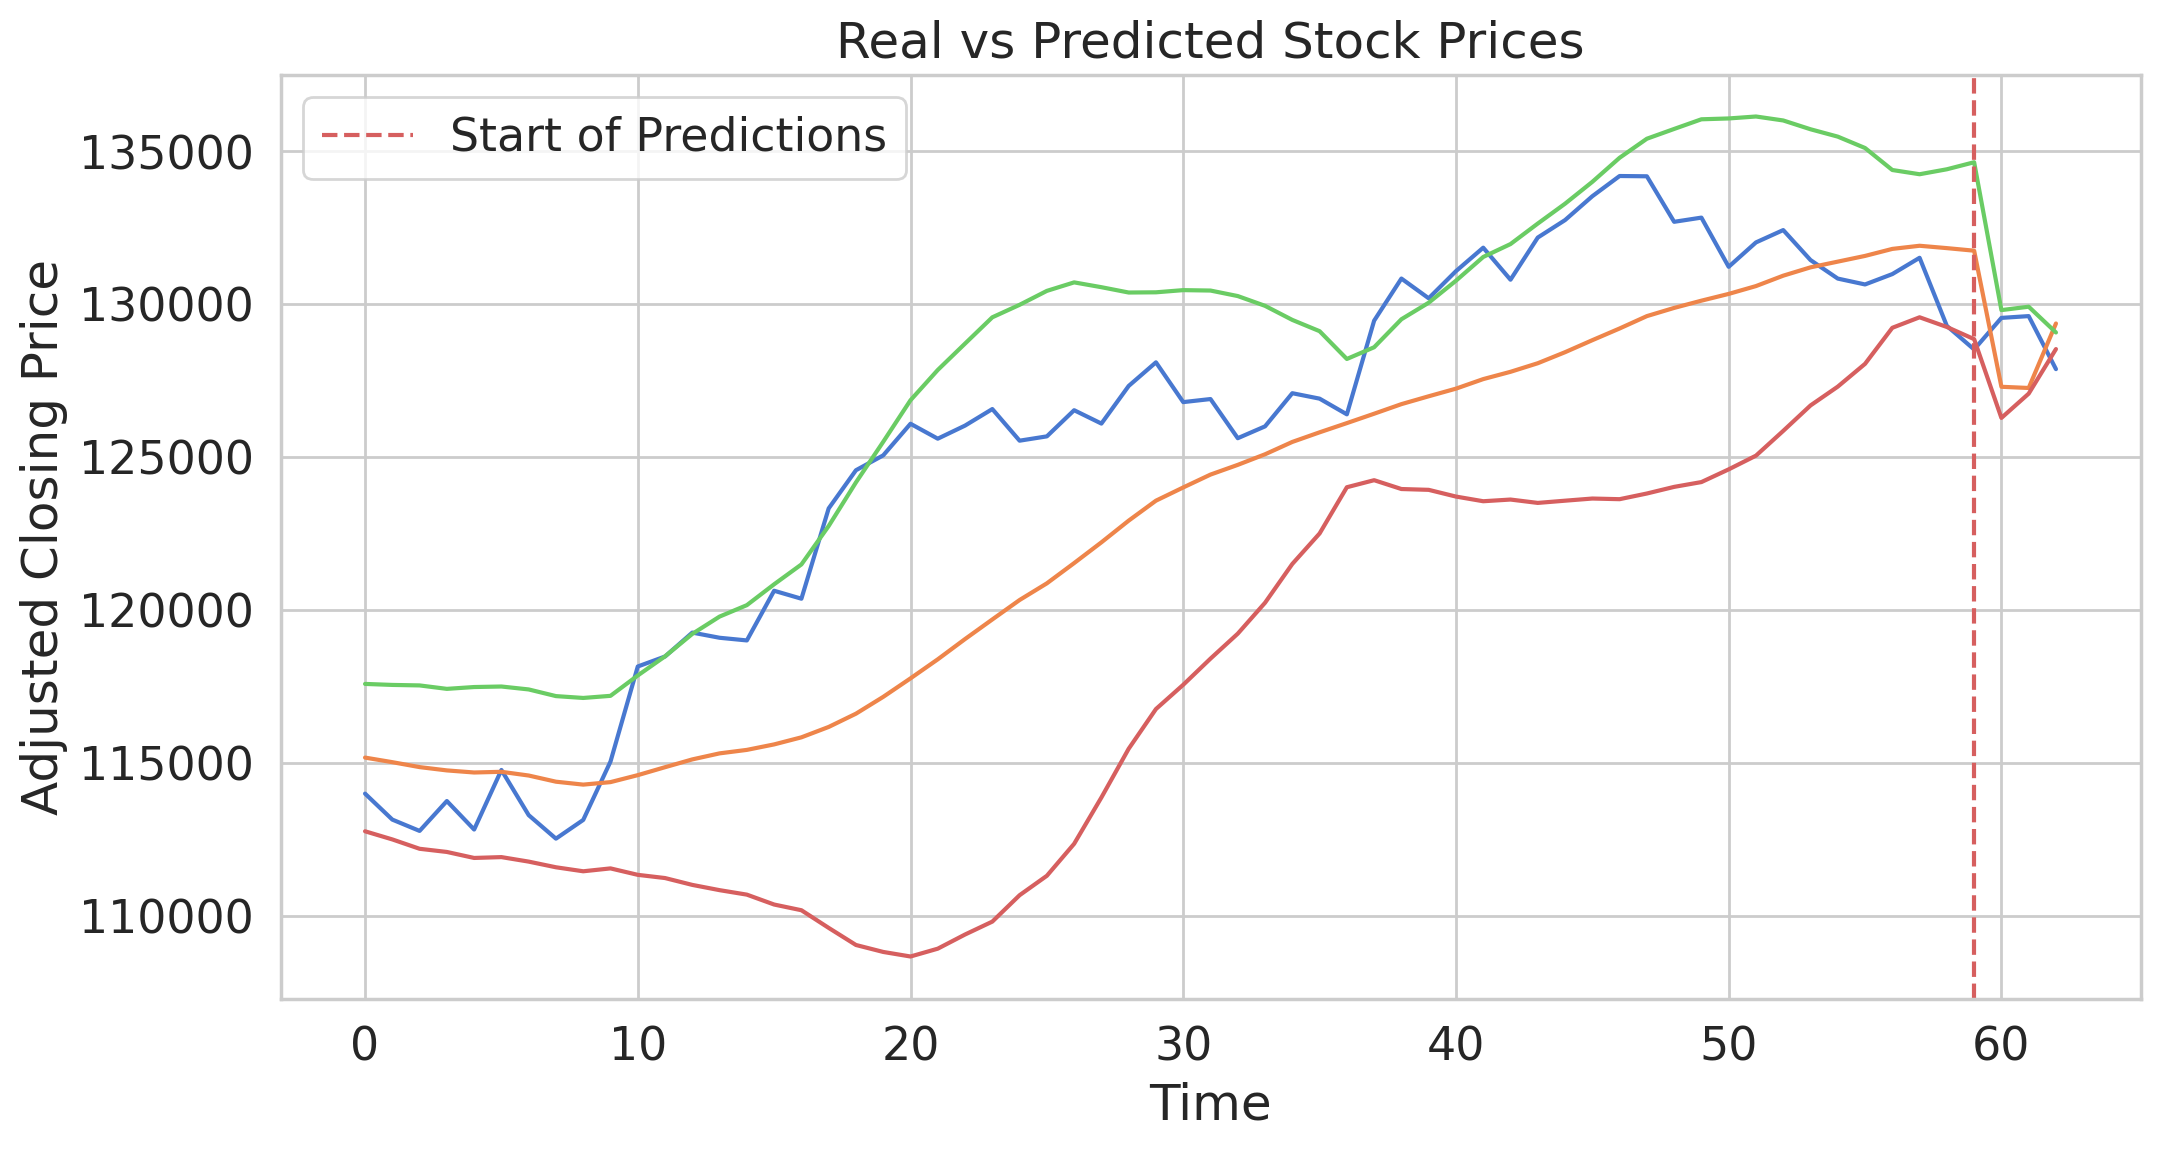

In [362]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data)
plt.axvline(x=lookback_period - 1, color='r', linestyle='--', label='Start of Predictions')
plt.title('Real vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()


In [363]:
predicted_df

,Adj Close,SMA,Upper_Bollinger,Lower_Bollinger
0,129555.945312,127303.859375,129810.695312,126285.718750
1,129614.437500,127264.578125,129921.968750,127079.828125
2,127880.921875,129373.007812,129078.976562,128536.632812


In [364]:
forecast_period = array_forecast_period[0]


# Organize the results in a DataFrame
df_past = data.reset_index()
df_past.rename(columns={'index': 'Date', 'Adj Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_period)
df_future['Forecast'] = predicted_df['Adj Close']

df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')
df_future


,Date,Actual,Forecast
0,2024-01-18,NaN,129555.945312
1,2024-01-19,NaN,129614.437500
2,2024-01-20,NaN,127880.921875


In [365]:
# monta a data limite para utilizar na linha de corte do grafico
from datetime import datetime, timedelta
data_final = datetime.strptime(end_date, "%Y-%m-%d")
um_dia = timedelta(days=1)
data_resultado = data_final - um_dia
data_limite = data_resultado.strftime("%Y-%m-%d")


df_forcast = results[results.index > '2023-12-20']
fig = px.line(df_forcast, title='Real vs Predicted Stock Prices')

fig.add_vline(x=data_limite, line_dash="dash", line_color="red")

fig.show()